# ЛІНГВІСТИЧНЕ МОДЕЛЮВАННЯ

**Мета:** побудування лінгвістичної моделі часового ряду

**Виконав:** студент групи ІП-32 _Олександр Ковальчук_

## Виконання роботи

### Підготовка до аналізу часового ряду та моделювання

Імпортуємо необхідні бібліотеки

In [1]:
%matplotlib inline

import re

from collections import defaultdict
from functools import partial
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

Зчитуємо числовий ряд із файлу згідно варіанту

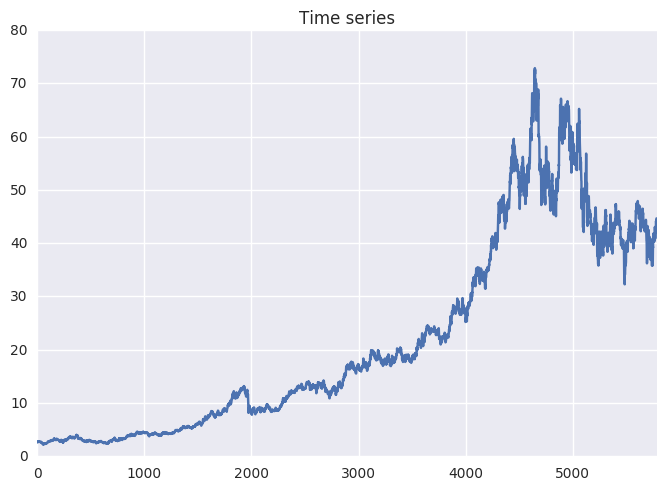

In [2]:
df = pd.read_csv('Dupont.csv', sep=';', header=None)  # Read dataframe
x = df[4]  # Get the column we need (indexing is zero based)
x.plot(title='Time series');

Обчислюємо різницеві ряди $X^{1}$, $X^2$, $X^3$, $X^4$, $X^5$, $X^6$:

In [3]:
diff_series = {
    i: x.diff(periods=i).dropna()
    for i in [1, 2, 6]
}

Задамо алфавіти різних потужностей:



| Потужність | Алфавіт                                                                                                                                                      |
|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 10         | e, d, c, b, a, A, B, C, D, E                                                                                                                                |
| 26         | m, l, k, j, i, h, g, f, e, d, c, b, a, A, B, C, D, E, F, G, H, I, J, K, L, M                                                                                |
| 52         | z, y, x, w, v, u, t, s, r, q, p, o, n, m, l, k, j, i, h, g, f, e, d, c, b, a, A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z |


In [4]:
alphabets = {
    len(a): list(a) for a in [
        "edcbaABCDE",
        "mlkjihgfedcbaABCDEFGHIJKLM",
        "zyxwvutsrqponmlkjihgfedcbaABCDEFGHIJKLMNOPQRSTUVWXYZ",
    ]
}

Опишемо алгоритм поділу послідовності на відрізки рівної довжини:

In [5]:
def get_slice_bounds(seq, n):
    min_, max_ = seq.min(), seq.max()

    sequence_range = max_ - min_
    slice_range = sequence_range / n
    
    bounds = []
    for i in range(n):
        lower_bound = min_ + slice_range * i
        upper_bound = lower_bound + slice_range
        
        if i == n-1:  # last bound
            upper_bound = max_
        
        bounds.append((lower_bound, upper_bound))
    
    return bounds

Опишемо функцію відображення $L$

$$ L(x_{i}) = a_{j} \quad \text{if } x_{i} \in I_{j-1,j} $$

In [6]:
def num_to_char(num, bounds, alphabet):
    for (idx, (min_, max_)) in zip(range(len(bounds)), bounds):
        if min_ <= num <= max_:
            return alphabet[idx]
    
    raise ValueError(
        'Value out of bounds: {}, [{}, {}]'
        .format(num, bounds[0][0], bounds[-1][1])
    )

Також для аналізу лінгвістичного ланцюжка необхідна функція підрахунку кількості входжень підрядка в рядок з урахуванням перекриттів. Тобто

$$ occurences("aaab", "aa") = 2 $$

Опишемо її:

In [7]:
def occurrences(text, sub):
    return len(re.findall('(?={0})'.format(re.escape(sub)), text))

Також опишемо допоміжну функцію, що будує матрицю слідування. Для неї використаємо описану вище функцію підрахунку входжень.

In [8]:
def build_follow_matrix(text, alphabet):
    usages = defaultdict(dict)

    for lead in alphabet:
        for follow in alphabet:
            pattern = lead + follow
            usages[lead][follow] = occurrences(text, pattern)
            
    mtx = pd.DataFrame(usages)
    mtx = mtx[alphabet]
    mtx = mtx.reindex(alphabet)
    
    return mtx

Для обчислення ймовірностей слідування скористаємося наступною функцією:

In [9]:
def calculate_probabilities(matrix):
    m = matrix.copy()
    
    for col in m:
        m[col] = m[col].apply(lambda x: x / m[col].sum())
    
    return m.fillna(0)

### Лінгвістичне моделювання з параметрами: $N=10; \quad X^{1}$ 

In [10]:
d1_series = diff_series[1]
alphabet = alphabets[10]

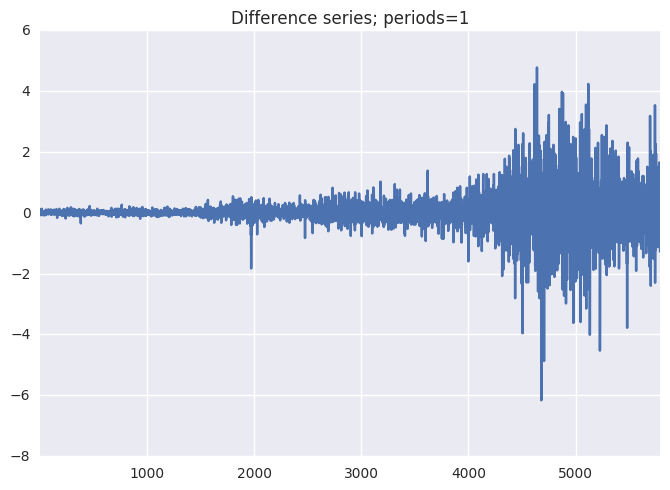

In [11]:
d1_series.plot(title='Difference series; periods=1');

Відсортуємо числовий ряд за зростанням:

In [12]:
d1_sorted = d1_series.sort_values()

Визначимо границі відрізків, на які буде розбито числовий ряд:

In [13]:
slice_bounds_d1_a10 = get_slice_bounds(d1_sorted, len(alphabet))

Застосуємо функцію відображення $L$ до числового ряду.

Отриманий результат переведемо у рядок, так як подальші операції стосуватимуться пошуку послідовностей символів у лінгвістичному ланцюжку.

In [14]:
y_1_a10 = d1_series.apply(lambda x: num_to_char(x, slice_bounds_d1_a10, alphabet))
linguistic_seq_1_a10 = ''.join(y_1_a10.tolist())

Побудуємо матрицю слідування:

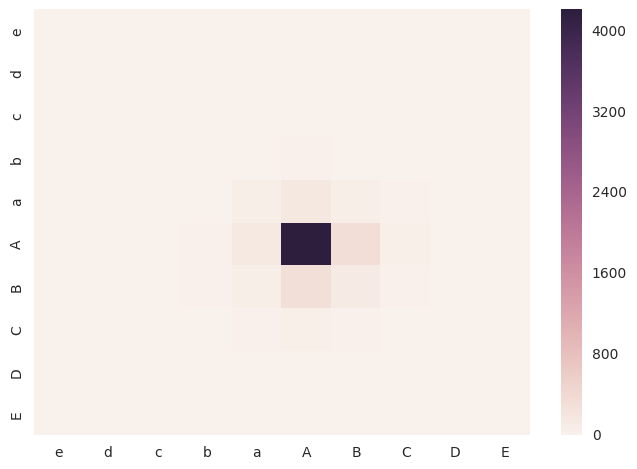

In [15]:
follow_matrix_1_a10 = build_follow_matrix(linguistic_seq_1_a10,
                                          alphabet=alphabet)

sns.heatmap(follow_matrix_1_a10);

**Примітка:** _теплова карта імовірністі слідування літери по вертикальній осі за літерою по горизонтальній осі_

Для більшої наочності побудуємо діаграму по логарифмічних значеннях:

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:953: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:954: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


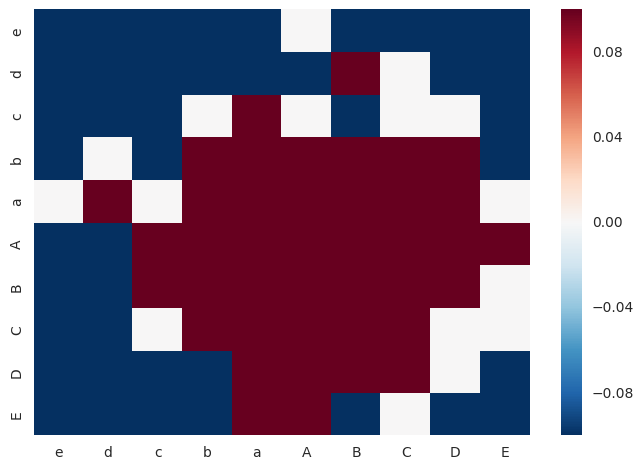

In [16]:
sns.heatmap(follow_matrix_1_a10.apply(np.log10));

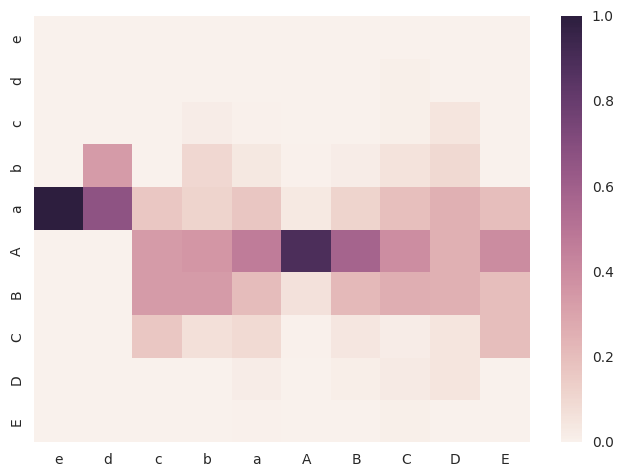

In [17]:
occurence_probabilities_1_a10 = calculate_probabilities(follow_matrix_1_a10)
sns.heatmap(occurence_probabilities_1_a10);

### Узагальнений процес обчислення ймовірностей слідування

Отже, можемо побудувати загальний алгоритм побудови матриць слідування та ймовірностей слідування. Він описаний наступною функцією:

In [18]:
def build_follow_and_probabilities_matrices(series, alphabet):
    d_sorted = series.sort_values()
    slice_bounds = get_slice_bounds(d_sorted, len(alphabet))
    
    y = series.apply(lambda x: num_to_char(x, slice_bounds, alphabet))
    linguistic_sequence = ''.join(y.tolist())
    
    follow_matrix = build_follow_matrix(linguistic_sequence,
                                        alphabet=alphabet)
    
    occurence_probabilities = calculate_probabilities(follow_matrix)
    
    return (follow_matrix, occurence_probabilities)

### Обчислення граматик слідування для інших алфавітів та різницевих рядів

Скористаємося описаною вище функцією для обчислення граматик слідування і для інших алавітів та ступенів різницевих рядів.

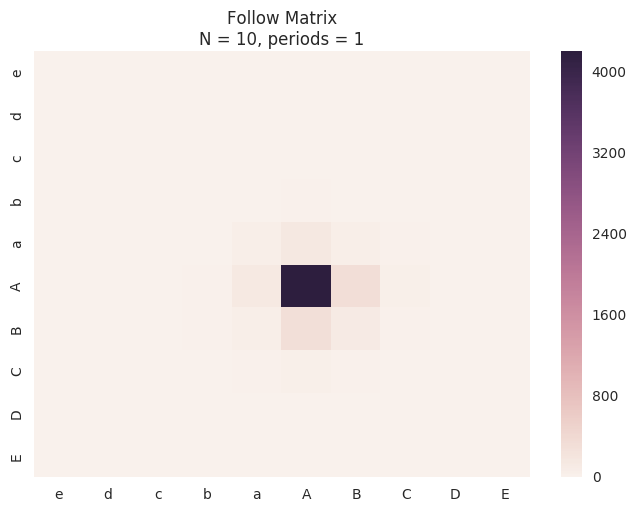

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:953: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:954: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


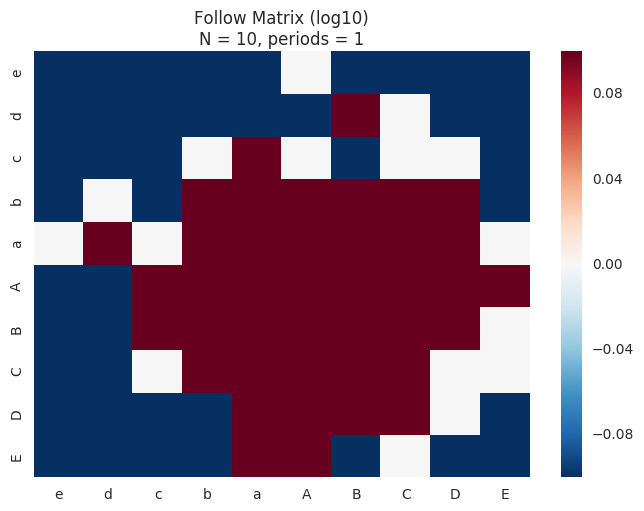

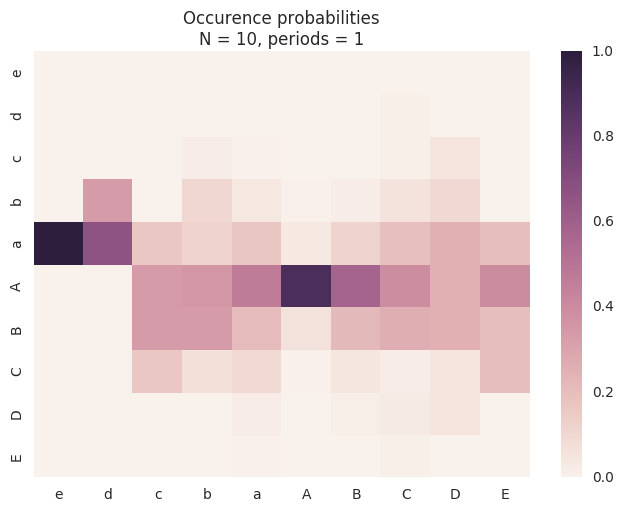

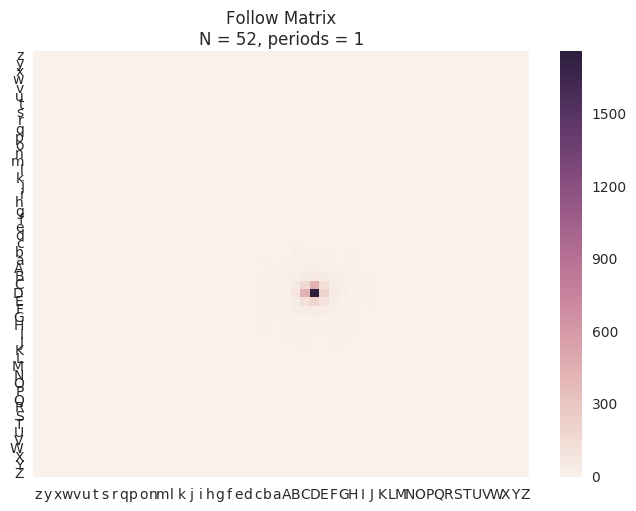

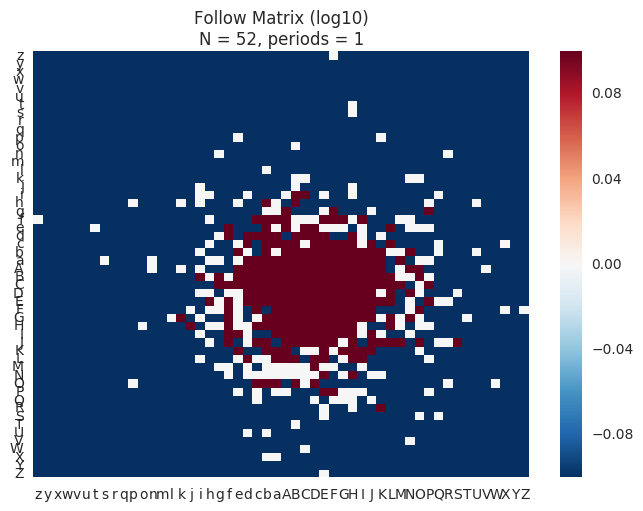

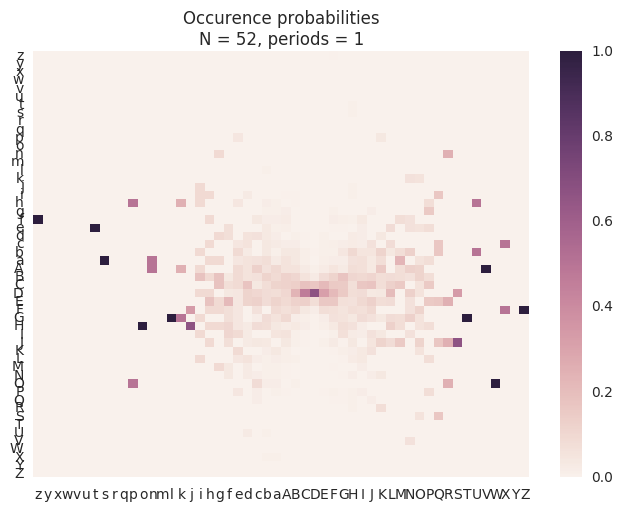

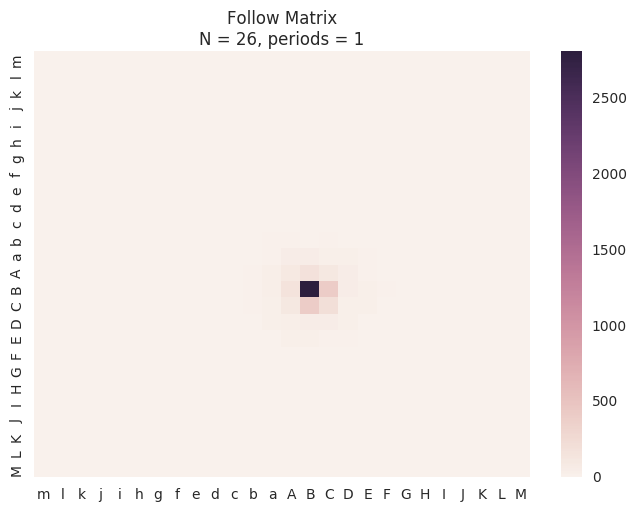

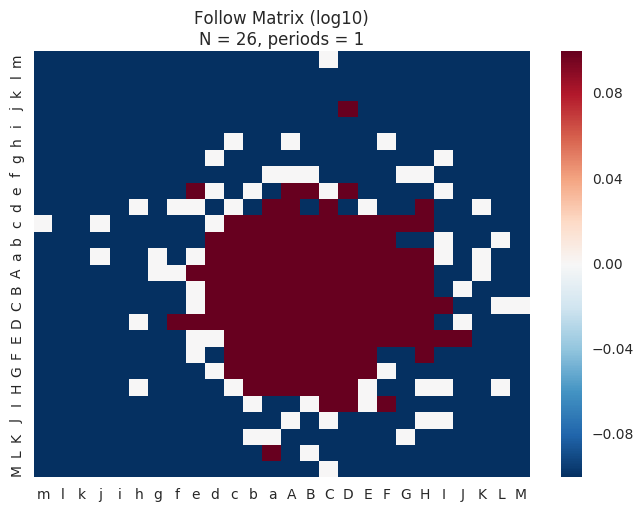

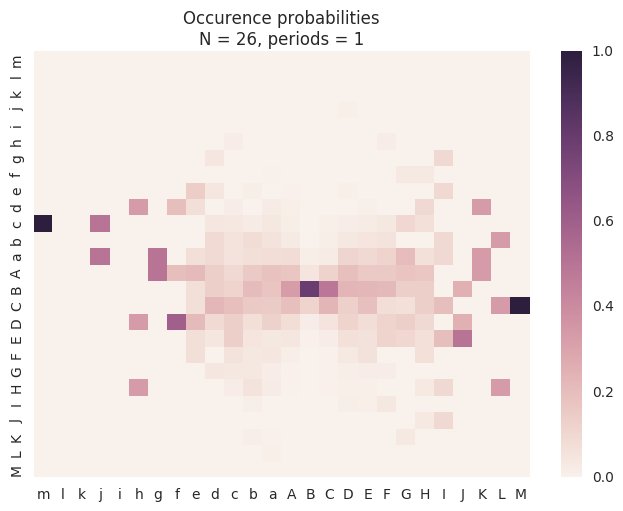

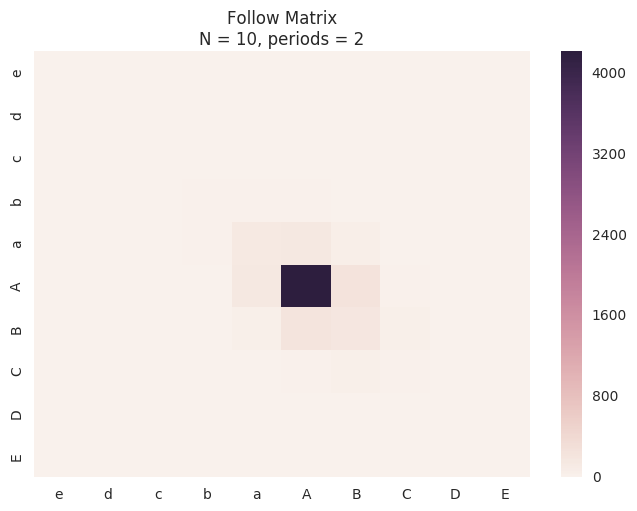

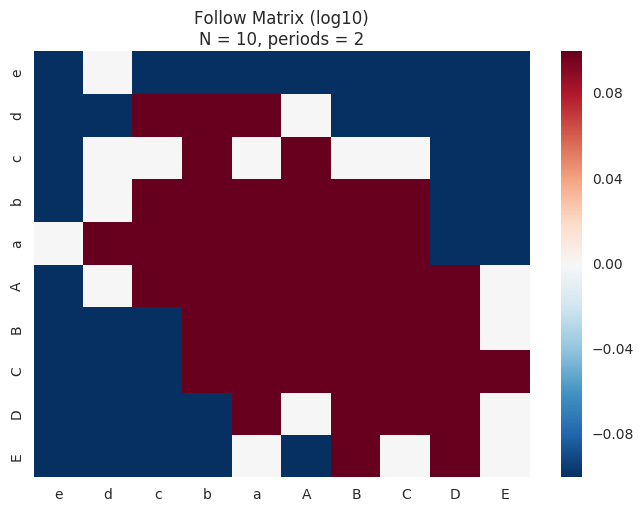

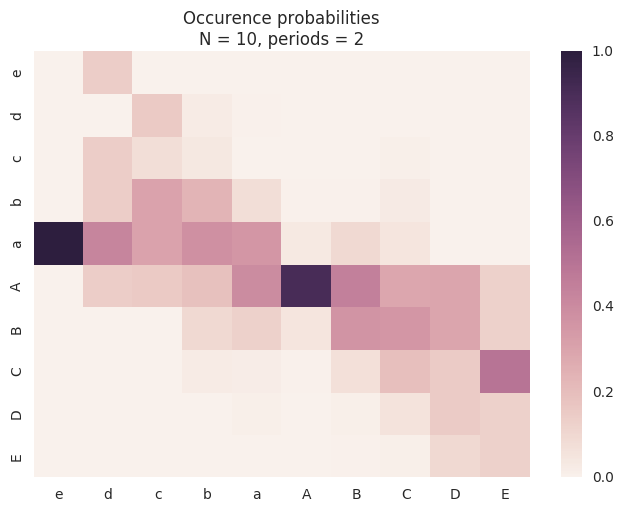

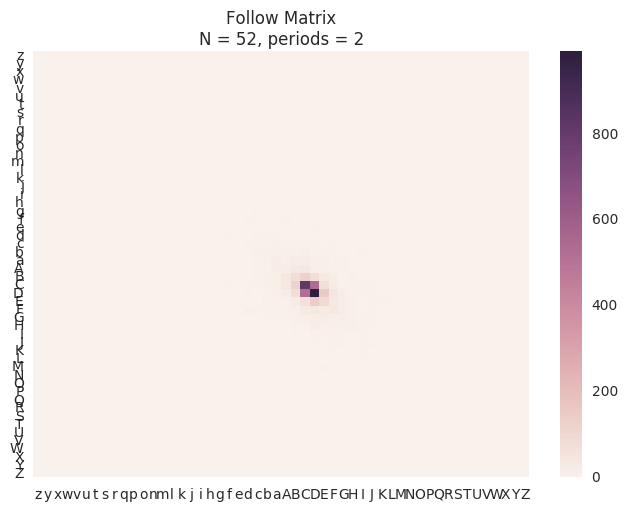

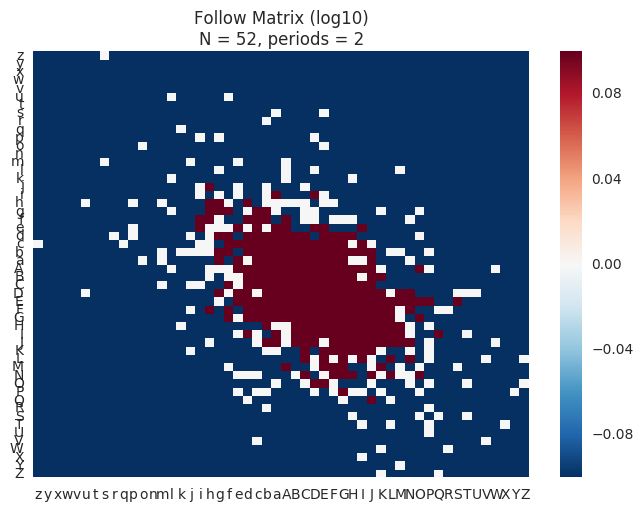

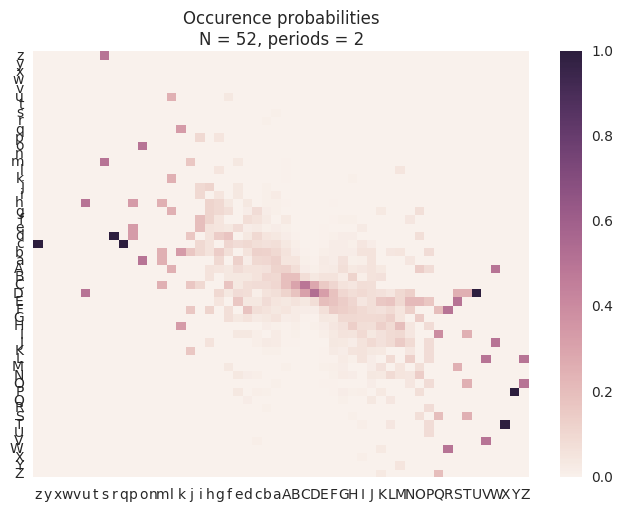

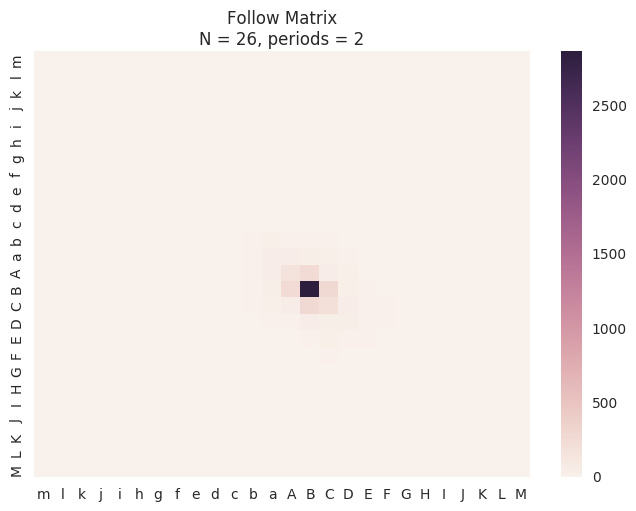

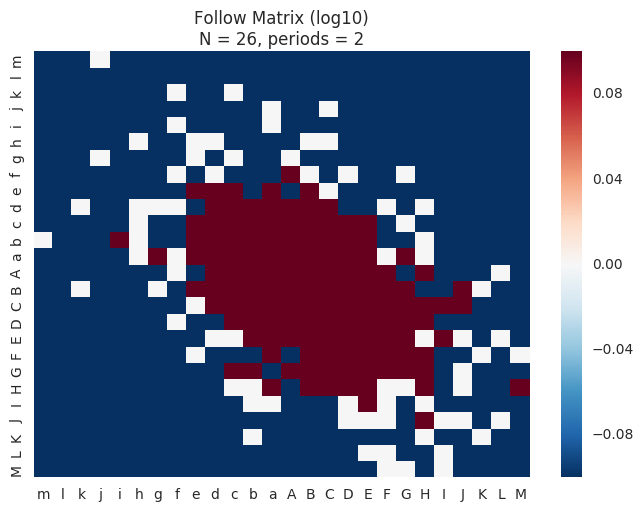

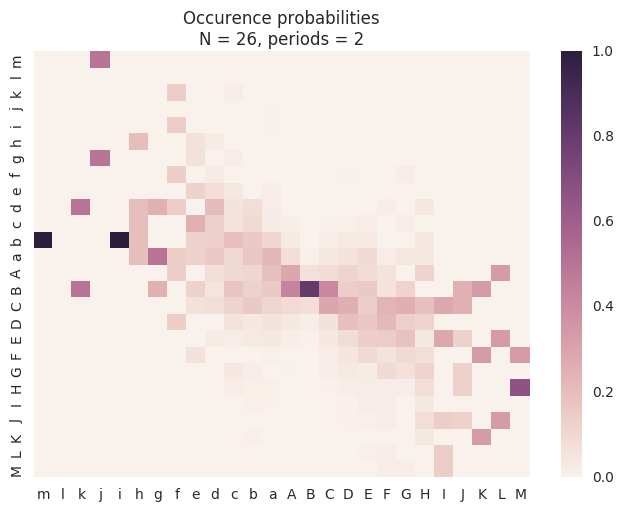

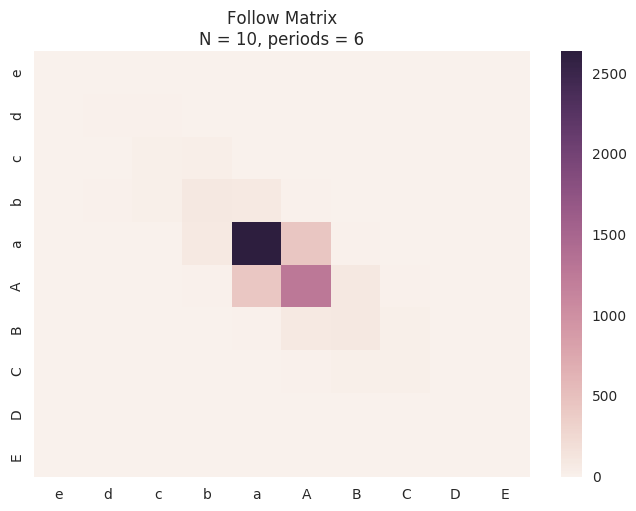

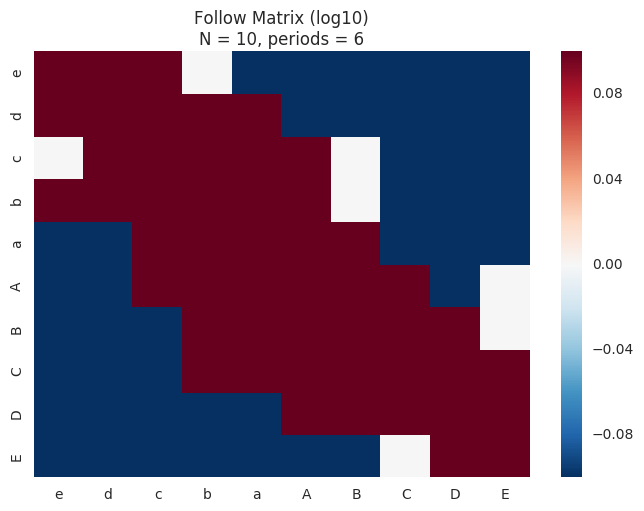

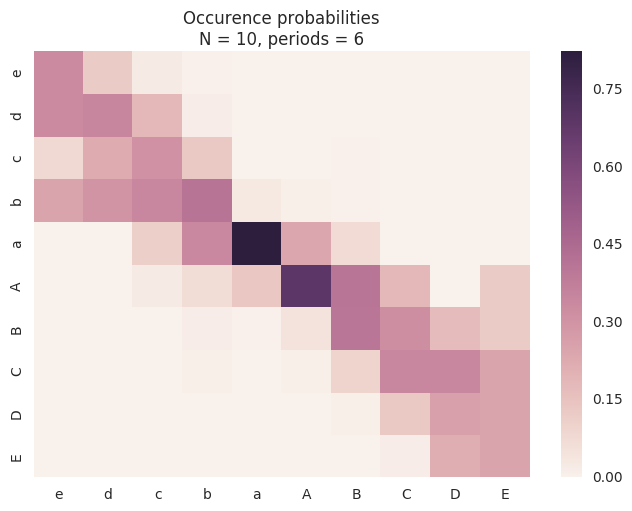

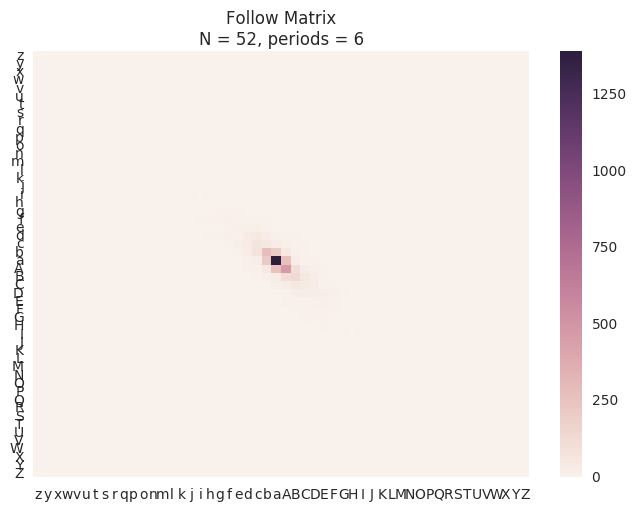

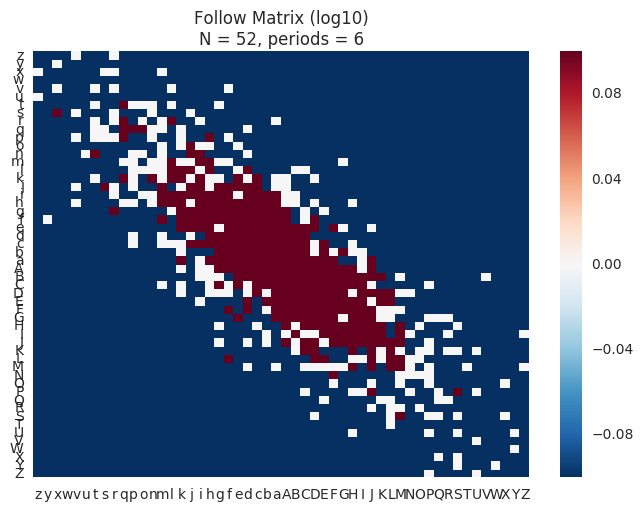

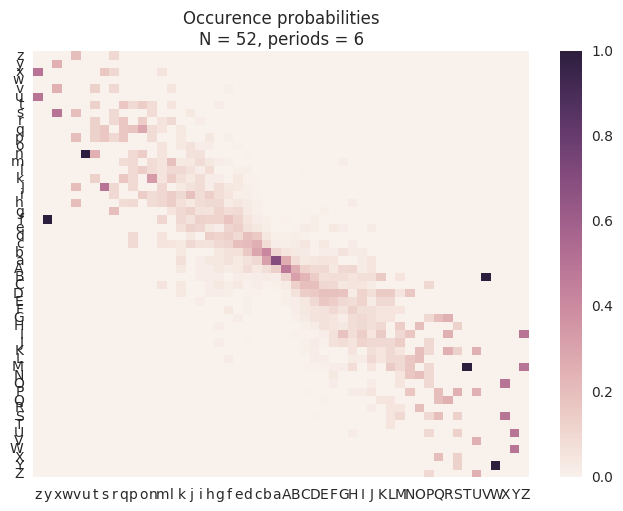

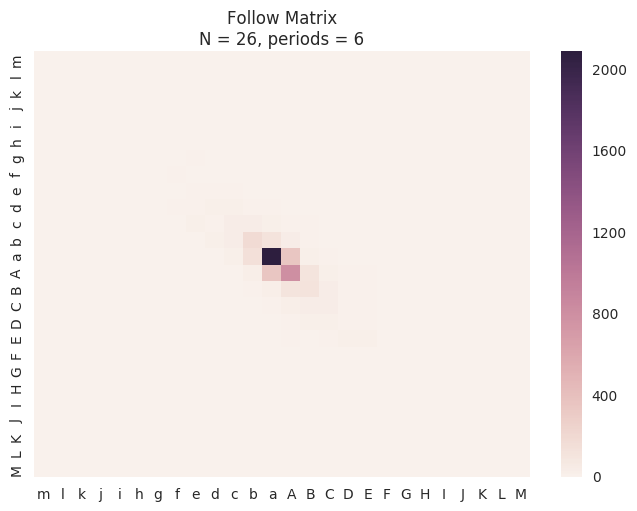

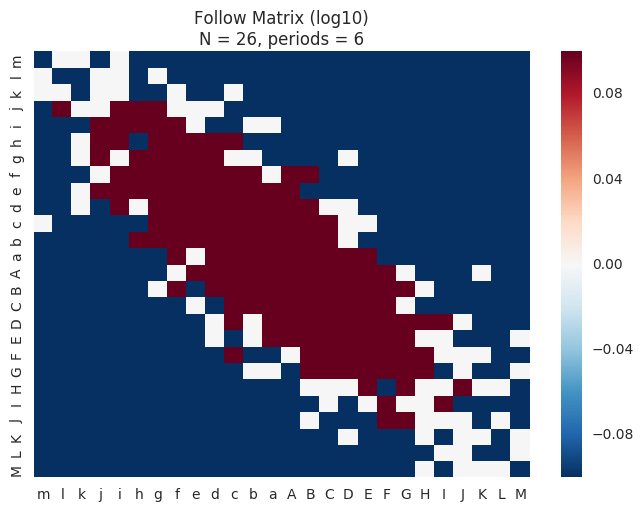

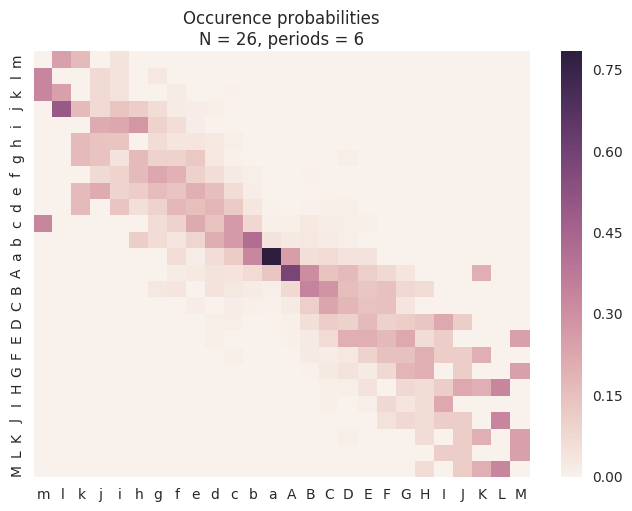

In [19]:
for period, n in product(diff_series, alphabets):
    series = diff_series[period]
    alphabet = alphabets[n]    
    follow_m, probabilities_m = (
        build_follow_and_probabilities_matrices(series, alphabet)
    )
    
    follow_log_m = follow_m.apply(np.log10)
    
    for (title, matrix) in [
        ('Follow Matrix', follow_m),
        ('Follow Matrix (log10)', follow_log_m),
        ('Occurence probabilities', probabilities_m),
    ]:
        ax = plt.axes()
        sns.heatmap(matrix, ax=ax)
        params = 'N = {}, periods = {}'.format(n, period)        
        ax.set_title(title + '\n' + params)
        plt.show();